# 0 Preliminaries
In this section we deal with imports and parameters for the execution of the reste of the code

In [5]:
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np
import os
import scipy.optimize as optim
import math

In [6]:
# Path to the folder of images
#database_path = '/home/dimitribouche/Bureau/ENSAE/CompressedSensing/CroppedYale'
database_path = '/Users/Remi/Documents/ENSAE/3A/Compressed Sensing/Reconaissance faciale/CroppedYale'
# Proportion of data to be used for learning (used for testing : 1 - learn_slice)
learn_slice = 0.75

# 1 Data base treatment
## 1.1 Read pgm function
In this subsection, we introduce a function to read the pgm images and store them in a numpy array

In [7]:
def read_pgm(pgmf):
    """
    Create a numpy array from a .pgm image file
    
    Args:
        pgmf (file) : a .pgm file opened in python
    Returns:
        numpy.ndarray. The .pgm file as a 2d numpy array
    """
    # Make sure that 
    #assert pgmf.readline() == 'P5\n'
    pgmf.readline().split()
    (width, height) = [int(i) for i in pgmf.readline().split()]
    depth = int(pgmf.readline())
    assert depth <= 255

    image = []
    for y in range(height):
        row = []
        for y in range(width):
            row.append(ord(pgmf.read(1)))
        image.append(row)
    return np.array(image)


[[ 24  22  22 ...  80  83  85]
 [ 24  22  20 ...  72  77  79]
 [ 22  20  19 ...  63  68  73]
 ...
 [ 69  71  74 ... 115 114 113]
 [ 64  68  71 ... 114 111 109]
 [ 63  66  70 ... 114 112 110]]


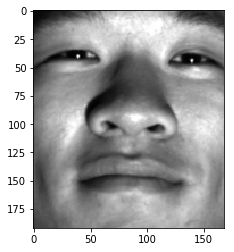

In [8]:
# Test of the read_pgm function on a given image
testfile = open(database_path + '/yaleB13/yaleB13_P00A-010E-20.pgm', 'rb')
testimage = read_pgm(testfile)
print(testimage)

# Show the image
plt.imshow(testimage, cmap="gray")
plt.show()

## 1.2 Load full database
In this subsection, we use our pgm reader to loop over the folders and files in the database to load the full database

In [9]:
def load_database(path, flatten=True):
    """
    Load the face database from computer
    
    Args:
        path (str): the folder containing the 'CroppedYale' folder
        flatten (bool): Should images be flattened ?
    
    Returns:
        list. A list of list of numpy array. Index of first list is for the individual, 
        index of the second list is the index of the image of the individual
    """
    database = []
    count = 0
    # Each folder contains the pictures for a given individual
    # We loop over folders
    for foldername in os.listdir(path):
        # Create empty container for the images of the individual
        database.append([])
        # Loop over images
        for filename in os.listdir(path + '/' + foldername):
            # Load only images files
            if filename.endswith(".pgm"):
                # Open file
                im = open(path + '/' + foldername + '/' + filename, 'rb')
                # Convert to numpy array, jump file is conversion is not a success
                try :
                    im_np = read_pgm(im)
                except ValueError :
                    # Skip the file "ambient" which are pictures of the background of the faces, unecessary in our case
                    continue
                # Append the new image to the list of images of the individual
                if flatten:
                    database[count].append(im_np.flatten())
                else:
                    database[count].append(im_np)
        count += 1
    return database

In [10]:
# Load the Yale B extended database using our loader
data = load_database(database_path, flatten=False)

In [11]:
print(data)

[[array([[80, 80, 84, ..., 63, 67, 71],
       [81, 79, 78, ..., 60, 61, 64],
       [80, 79, 82, ..., 61, 59, 62],
       ...,
       [12, 12, 19, ..., 21, 18, 14],
       [12, 12, 15, ..., 14, 14, 14],
       [12, 12, 12, ..., 12, 12, 11]]), array([[94, 94, 96, ..., 72, 76, 79],
       [87, 87, 94, ..., 66, 72, 75],
       [88, 91, 95, ..., 70, 68, 67],
       ...,
       [ 5,  7,  8, ...,  8,  9,  7],
       [ 5,  7,  8, ...,  7,  8,  9],
       [ 4,  7,  7, ...,  6,  7,  8]]), array([[59, 66, 77, ..., 73, 67, 58],
       [67, 76, 82, ..., 71, 72, 72],
       [66, 75, 84, ..., 79, 76, 76],
       ...,
       [ 4,  4,  4, ...,  3,  7,  6],
       [ 4,  5,  5, ...,  4,  5,  6],
       [ 3,  4,  5, ...,  5,  7,  7]]), array([[16, 18, 22, ..., 13, 13, 12],
       [14, 17, 19, ..., 13, 14, 14],
       [14, 16, 18, ..., 12, 13, 11],
       ...,
       [ 1,  2,  2, ...,  3,  5,  5],
       [ 1,  2,  1, ...,  4,  4,  5],
       [ 1,  1,  1, ...,  7,  6,  5]]), array([[69, 71, 77, ..., 53, 5

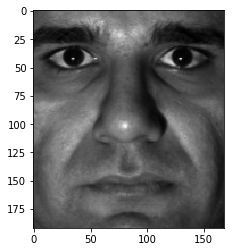

In [12]:
# Test : show a face in the database
# The index states that this is the 9th image for the 7th individual
plt.imshow(data[7][9], cmap="gray")
plt.show()

## 1.3 Division of the data in test/learn sets
In this subsection we introduce the divide_learn_test function that divide the database two : a learn set and a test set

In [13]:
def divide_learn_test(faces_data, learn_slice=0.75):
    """
    Divide the faces database into a learn set and a test set
    
    Args : 
        faces_data (list) : The database in the format of output from load_database function
        learn_slice (float) : How much of the database should be used for learning ? (0.5 : half)
    
    Returns :
        tuple. A tuple of list, the learn set and the test set
    """
    learn_data = []
    test_data = []
    for person in range(0, len(faces_data)):
        n_images = len(faces_data[person])
        shuffle(faces_data[person])
        split_index = int(learn_slice * n_images)
        learn_data.append(faces_data[person][0: split_index])
        test_data.append(faces_data[person][split_index: ])
    return learn_data, test_data

In [14]:
# Divide data base in learn and test using the divide_learn_test function
data_learn, data_test = divide_learn_test(data, learn_slice=learn_slice)

In [15]:
print(data_learn)

[[array([[ 94,  96, 104, ...,  53,  50,  42],
       [ 92,  97,  99, ...,  52,  54,  46],
       [ 90,  94,  98, ...,  52,  56,  49],
       ...,
       [ 25,  37,  41, ...,  12,  15,  15],
       [ 29,  31,  35, ...,  11,  13,  14],
       [ 28,  27,  30, ...,  14,  16,  14]]), array([[  5,   5,   5, ..., 174, 186, 178],
       [  5,   4,   5, ..., 159, 167, 164],
       [  4,   4,   6, ..., 153, 160, 161],
       ...,
       [  2,   3,   3, ...,  42,  47,  45],
       [  3,   3,   4, ...,  41,  39,  45],
       [  2,   3,   4, ...,  49,  56,  65]]), array([[212, 208, 207, ...,  14,  15,  13],
       [229, 218, 226, ...,  15,  15,  14],
       [207, 218, 210, ...,  13,  15,  15],
       ...,
       [ 78,  99, 101, ...,   4,   6,   4],
       [129, 105,  92, ...,   3,   5,   5],
       [ 90,  86,  87, ...,   5,   6,   7]]), array([[246, 229, 231, ...,  14,  14,  12],
       [233, 239, 245, ...,  14,  14,  14],
       [217, 227, 235, ...,  13,  14,  14],
       ...,
       [ 63,  67,  7

In [16]:
print(len(data_learn[0]))

48


In [17]:
print(data_test)

[[array([[  3,   3,   4, ..., 182, 167, 166],
       [  3,   3,   3, ..., 249, 215, 177],
       [  3,   3,   4, ..., 197, 234, 236],
       ...,
       [  0,   1,   1, ...,  94, 120, 117],
       [  1,   1,   1, ...,  90, 108, 118],
       [  0,   1,   0, ...,  87,  97, 113]]), array([[15, 16, 18, ..., 69, 71, 64],
       [14, 14, 16, ..., 72, 78, 76],
       [12, 13, 15, ..., 82, 74, 76],
       ...,
       [ 1,  1,  1, ...,  4,  6,  6],
       [ 2,  2,  1, ...,  4,  7,  7],
       [ 2,  1,  2, ...,  4,  6,  6]]), array([[73, 73, 80, ..., 75, 74, 66],
       [69, 74, 78, ..., 69, 74, 66],
       [69, 71, 75, ..., 70, 72, 72],
       ...,
       [ 5,  7,  6, ..., 13, 13, 11],
       [ 5,  6,  6, ...,  9,  9, 11],
       [ 4,  6,  6, ..., 10, 12, 12]]), array([[68, 67, 71, ..., 10, 10,  9],
       [69, 71, 70, ..., 10, 10, 10],
       [69, 70, 70, ..., 11, 10, 10],
       ...,
       [38, 51, 63, ..., 15, 17, 24],
       [46, 48, 59, ..., 14, 13, 17],
       [46, 56, 55, ..., 14, 13, 1

## 1.4 Stack learn data in a matrix
In this section we introduce a function to stack the learn data in a matrix

In [18]:
def stack_images(faces_data):
    """
    input: list of face images
    output: np.array. Matrix of vectorized image concatenated into columns
    """
    dim_stacked = faces_data[0][0].shape[0] * faces_data[0][0].shape[1]
    n_images = sum([len(faces_data[i]) for i in range(0, len(faces_data))])
    images_matrix = np.zeros(shape=(dim_stacked, n_images), dtype=np.int64)
    cum_ind = 0
    for i in range(0, len(faces_data)):
        len(faces_data[i])
        for j in range(0, len(faces_data[i])):
            images_matrix[:, j + cum_ind] = faces_data[i][j].flatten().T
        cum_ind += len(faces_data[i])
    return images_matrix

In [19]:
# Create and fill the matrix of images using the stack_images function defined above
im_mat = stack_images(data_learn)
print(im_mat)
print(im_mat.shape)

[[ 94   5 212 ... 110 163   4]
 [ 96   5 208 ... 110 171   4]
 [104   5 207 ... 115 160   5]
 ...
 [ 14  49   5 ...   3   0   1]
 [ 16  56   6 ...   2   0   3]
 [ 14  65   7 ...   3   0   3]]
(32256, 1809)


## 1.5 Stack test data in vectors
In this section we introduce a function to stack the test data in list of vectors

In [20]:
# Create and fill the vectors of test images using the stack_images function defined above
def stack_data_to_vec(data_test):
    test_im_mat = stack_images(data_test)
    nb_cols = test_im_mat.shape[1]
    test_im_vec = []
    for i in range(0,nb_cols):
        test_im_vec.append(np.array(test_im_mat[:,i]))
    nb_test_im = len(test_im_vec)
    N = len(test_im_mat[:,0])
    return test_im_vec, nb_test_im, N

In [21]:
test_im_vec, nb_test_im, N = stack_data_to_vec(data_test)
print(nb_test_im)
print(N)
print(test_im_vec)

615
32256
[array([  3,   3,   4, ...,  87,  97, 113], dtype=int64), array([15, 16, 18, ...,  4,  6,  6], dtype=int64), array([73, 73, 80, ..., 10, 12, 12], dtype=int64), array([68, 67, 71, ..., 14, 13, 13], dtype=int64), array([146, 149, 153, ...,   4,   5,   6], dtype=int64), array([48, 50, 55, ..., 28, 29, 33], dtype=int64), array([158, 150, 152, ...,   4,   7,   7], dtype=int64), array([ 6,  7,  8, ..., 20, 34, 49], dtype=int64), array([47, 50, 54, ..., 30, 29, 31], dtype=int64), array([ 5,  5,  5, ..., 80, 92, 95], dtype=int64), array([ 9,  9, 10, ..., 48, 49, 55], dtype=int64), array([90, 90, 93, ..., 17, 14, 13], dtype=int64), array([65, 67, 72, ..., 22, 28, 32], dtype=int64), array([71, 83, 90, ...,  4,  5,  7], dtype=int64), array([7, 8, 8, ..., 6, 7, 9], dtype=int64), array([  6,   7,   8, ...,  76,  95, 117], dtype=int64), array([ 5,  3,  4, ..., 59, 68, 87], dtype=int64), array([  5,   5,   5, ...,  90,  96, 110], dtype=int64), array([147, 150, 148, ...,  13,  14,  14], dtyp

##Compressed sensing -- presentation of the problem (from G.Lecué notebook)
In Compressed sensing, one is given a measurement matrice $A\in\R^{m\times N}$ and a measures vector $y=Ax$ of some unknown signal $x\in\R^N$. We want to reconstruct exactly $x$ given $y$ and $A$. 

One way to look at this problem is as a highly underdetermined linear system: one has $m$ equations but $N>>m$ unknown variables. So what is going to save the day is that the signal to recover has a short support of size $s$ where $s<<N$. 

A classical procedure is the Basis Pursuit:
$$ \hat x \in\argmin_{t\in\R^N: At = y}\norm{t}_1.$$
This procedure is searching for the vector with the smallest $\ell_1$-norm in the set of solutions to the equation $Ax=y$.

##Basis Pursuit as a linear program
One can recast the Basis Pursuit procedure as a linear program. 

Let $A\in\R^{m\times N}$ be a measurements matrix and $y\in\R^m$ be a measurements vector. We consider the following linear programming problem (LP):


> $$\min_{z^+,z^-\in\bR^n} \sum_{j=1}^n z_i^+ + z_i^-$$

> subject to $$ [A|-A]\left[\begin{array}{c} z^+\\ z^-\end{array}\right] = y \mbox{ and } \left[\begin{array}{c} z^+\\ z^-\end{array}\right]\geq 0 $$



For any $x\in\R^N$, we denote by  $x^+\in\R^N$ and $x^-\in\R^N$ vectors with coordinates given for any $j=1,\ldots,N$ by 
\begin{equation*}
(x^+)_j = \max(0,x_j) \mbox{ et } (x^-)_j = \max(0,-x_j).
\end{equation*} 
There is equivalence between the Basis Pursuit procedure and (LP) in the following way: 

>	If $\hat x$ is a solution to (BP) then $(\hat x^+, \hat x^-)$ is solution to (LP)

>	If $(\hat z^+, \hat z^-)$ is a solution to (LP) then $\hat z^+-\hat z^-$ is solution to (BP).

# Solving (BP) via scipy.optim.linprog

Let $A\in\bR^{m\times N}$ and $y\in\R^m$. (LP) is defined by:

> $$(\hat z^+, \hat z^-)\in\argmin_{(z^+,z^-)\in\bR^{2N}} \sum_{j=1}^n z_i^+ + z_i^-  \mbox{ subject to } [A|-A]\left[\begin{array}{c} z^+\\ z^-\end{array}\right] = y \mbox{ and } \left[\begin{array}{c} z^+\\ z^-\end{array}\right]\geq 0 $$

Solution to (BP) is recovered via $t= \hat z^+- \hat z^-$.

Linear Programming problem considered in scipy.optim.linprog have the following form: 


Minimize:     c^T * x

Subject to:   $$A_{ub} * x <= b_{ub}$$
              $$A_{eq} * x = b_{eq}$$
              $$bounds[i][0] < x_i < bounds[i][1]$$

In the case of (LP) :

$$c = \left[\begin{array}{c} \1 \\ \1 \end{array}\right]\in\R^{2N}; \hspace{1cm} A_{eq} = [A|-A]\in\R^{m\times 2N};\hspace{1cm} b_{eq} = y\in\R^m$$

In [57]:
#Input
A = im_mat
At = np.transpose(A)
y = test_im_vec[0]
m = A.shape[0]
N = A.shape[1]
print(A.shape)
print(At.shape)
print(y.shape)

(32256, 1809)
(1809, 32256)
(32256,)


In [23]:
#Augmented Lagrange Muliplier
#Define some functions
def shrink(x,lamb):
    n=len(x)
    s=np.zeros(n)
    for i in range(n):
        if x[i]>lamb:
            s[i]=x[i]-lamb
        elif x[i]<-lamb:
            s[i]=x[i]+lamb
    return s
    
def norm1(x):
    return np.linalg.norm(x,1)

def norm2(x):
    return np.linalg.norm(x,2)

In [94]:
#see http://www.numerical.rl.ac.uk/people/nimg/oupartc/lectures/parts/part5.2.pdf for suggestions for mu
c=c_new=np.zeros(N)
e_new=y
e=nu=nu_new=np.zeros(m)
mu=1
eps=0.1
eps1=0.001
eps2=0.001
mult=2

In [49]:
#take a bit of time
gamma=max(np.linalg.eigvals(At.dot(A)))

In [79]:
shrink(y-A.dot(c)+nu/mu,1/mu)

array([33., 36., 41., ..., 27., 31., 37.])

In [95]:
#while norm1(c_new-c)>eps1 or norm1(e_new-e)>eps1 or norm1(nu_new-nu)>eps1:
while norm2(y-A.dot(c))>eps:
    
    c=c_new
    e=e_new
    nu=nu_new
    #mu=mult*mu
    
    #update e
    e_new=shrink(y-A.dot(c)+nu/mu,1/mu)
    
    #update c
    t_new=1
    z=c
    w=c+10*eps2
    w_new=c
    
    while norm1(w_new-w)>eps2:
        w=w_new
        w_new=shrink(z+(1/gamma)*At.dot(
            (y-A.dot(z)-e_new+nu/mu)),
                 1/(mu*gamma))
        t=t_new
        t_new=(1+math.sqrt(1+4*t*t))/2
        z=w_new+((t-1)/t_new)*(w_new-w)
        
        print('t_new=',t_new)
        print('z=',z)
        print('w_new=',w_new)
        
    c_new=w_new
    
    #update nu
    nu_new= nu+mu*(y-A.dot(c_new)-e_new)
    
    print('c_new=',c_new)
    print('e_new=',e_new)
    print('nu_new=',nu_new)
    print('mu=',mu)

t_new= 1.618033988749895
z= [6.90933086e-06 1.10717990e-05 1.07167845e-05 ... 2.63316873e-06
 9.05139111e-06 4.91741486e-06]
w_new= [6.90933086e-06 1.10717990e-05 1.07167845e-05 ... 2.63316873e-06
 9.05139111e-06 4.91741486e-06]
t_new= 2.193527085331054
z= [7.25055443e-06 1.11645963e-05 1.06261442e-05 ... 3.00011351e-06
 9.19692742e-06 5.20602289e-06]
w_new= [7.17554707e-06 1.11441977e-05 1.06460687e-05 ... 2.91945215e-06
 9.16493580e-06 5.14258142e-06]
c_new= [7.17554707e-06 1.11441977e-05 1.06460687e-05 ... 2.91945215e-06
 9.16493580e-06 5.14258142e-06]
e_new= [33. 36. 41. ... 27. 31. 37.]
nu_new= [0.27746284 0.26148743 0.24500641 ... 0.4816002  0.49734175 0.50731013]
mu= 1
t_new= 1.618033988749895
z= [1.40848779e-05 2.22159968e-05 2.13628532e-05 ... 5.55262088e-06
 1.82163269e-05 1.00599963e-05]
w_new= [1.40848779e-05 2.22159968e-05 2.13628532e-05 ... 5.55262088e-06
 1.82163269e-05 1.00599963e-05]
t_new= 2.193527085331054
z= [1.44261015e-05 2.23087941e-05 2.12722129e-05 ... 5.919565

t_new= 2.193527085331054
z= [8.54064317e-05 1.33510036e-04 1.27262352e-04 ... 3.43802484e-05
 1.09919012e-04 6.13859826e-05]
w_new= [8.53457115e-05 1.33477713e-04 1.27277697e-04 ... 3.43249660e-05
 1.09874497e-04 6.13286712e-05]
c_new= [8.53457115e-05 1.33477713e-04 1.27277697e-04 ... 3.43249660e-05
 1.09874497e-04 6.13286712e-05]
e_new= [25.39768683 28.20708882 33.01016041 ... 21.78610125 25.97476344
 32.09409265]
nu_new= [0.2976646  0.28199451 0.2657341  ... 0.48361103 0.49928686 0.50916678]
mu= 1
t_new= 1.618033988749895
z= [9.20712461e-05 1.44432932e-04 1.37847598e-04 ... 3.68057758e-05
 1.18839053e-04 6.61411261e-05]
w_new= [9.20712461e-05 1.44432932e-04 1.37847598e-04 ... 3.68057758e-05
 1.18839053e-04 6.61411261e-05]
t_new= 2.193527085331054
z= [9.23376367e-05 1.44587959e-04 1.37782712e-04 ... 3.70364650e-05
 1.19046272e-04 6.63957238e-05]
w_new= [9.22790791e-05 1.44553882e-04 1.37796975e-04 ... 3.69857552e-05
 1.19000721e-04 6.63397584e-05]
c_new= [9.22790791e-05 1.44553882e-04

c_new= [1.59861357e-04 2.55104881e-04 2.42515706e-04 ... 6.13887987e-05
 2.09831184e-04 1.15488485e-04]
e_new= [17.84658509 20.48571133 25.1111476  ... 16.12187893 20.48262126
 26.71002528]
nu_new= [0.32753957 0.31223286 0.29618724 ... 0.48636924 0.50198827 0.51176966]
mu= 1
t_new= 1.618033988749895
z= [1.66316998e-04 2.65940535e-04 2.52934534e-04 ... 6.36155735e-05
 2.18665542e-04 1.20157194e-04]
w_new= [1.66316998e-04 2.65940535e-04 2.52934534e-04 ... 6.36155735e-05
 2.18665542e-04 1.20157194e-04]
t_new= 2.193527085331054
z= [1.66433098e-04 2.66193398e-04 2.52930401e-04 ... 6.35935864e-05
 2.18911576e-04 1.20348614e-04]
w_new= [1.66407577e-04 2.66137814e-04 2.52931309e-04 ... 6.35984196e-05
 2.18857493e-04 1.20306537e-04]
c_new= [1.66407577e-04 2.66137814e-04 2.52931309e-04 ... 6.35984196e-05
 2.18857493e-04 1.20306537e-04]
e_new= [17.1770457  19.80090255 24.41031583 ... 15.60852183 19.98487845
 26.22205534]
nu_new= [0.33023829 0.31496929 0.29894851 ... 0.48665874 0.50227281 0.512046

t_new= 1.618033988749895
z= [2.35157025e-04 3.86897643e-04 3.66642212e-04 ... 8.47098267e-05
 3.16944466e-04 1.71831798e-04]
w_new= [2.35157025e-04 3.86897643e-04 3.66642212e-04 ... 8.47098267e-05
 3.16944466e-04 1.71831798e-04]
t_new= 2.193527085331054
z= [2.35036713e-04 3.87272109e-04 3.66713816e-04 ... 8.43601545e-05
 3.17203062e-04 1.71943308e-04]
w_new= [2.35063160e-04 3.87189794e-04 3.66698076e-04 ... 8.44370190e-05
 3.17146218e-04 1.71918796e-04]
c_new= [2.35063160e-04 3.87189794e-04 3.66698076e-04 ... 8.44370190e-05
 3.17146218e-04 1.71918796e-04]
e_new= [10.03790297 12.49647066 16.93119277 ...  9.98264445 14.53042154
 20.87455365]
nu_new= [0.3689559  0.35412196 0.33834776 ... 0.49029642 0.50584904 0.51552596]
mu= 1
t_new= 1.618033988749895
z= [2.41108657e-04 3.97859833e-04 3.76910278e-04 ... 8.63058484e-05
 3.25769768e-04 1.76387341e-04]
w_new= [2.41108657e-04 3.97859833e-04 3.76910278e-04 ... 8.63058484e-05
 3.25769768e-04 1.76387341e-04]
t_new= 2.193527085331054
z= [2.409677

t_new= 2.193527085331054
z= [2.96796801e-04 5.07316135e-04 4.78821290e-04 ... 9.81475443e-05
 4.12896484e-04 2.20126783e-04]
w_new= [2.96891612e-04 5.07209793e-04 4.78789109e-04 ... 9.83098061e-05
 4.12844054e-04 2.20133692e-04]
c_new= [2.96891612e-04 5.07209793e-04 4.78789109e-04 ... 9.83098061e-05
 4.12844054e-04 2.20133692e-04]
e_new= [ 3.37193641  5.66988964  9.93248363 ...  4.40144517  9.11971244
 15.56953548]
nu_new= [0.41831571 0.40394314 0.38842486 ... 0.49485523 0.51030093 0.51984331]
mu= 1
t_new= 1.618033988749895
z= [3.02439192e-04 5.17651677e-04 4.88740791e-04 ... 9.97808769e-05
 4.21193074e-04 2.24335138e-04]
w_new= [3.02439192e-04 5.17651677e-04 4.88740791e-04 ... 9.97808769e-05
 4.21193074e-04 2.24335138e-04]
t_new= 2.193527085331054
z= [3.01977540e-04 5.18145850e-04 4.88892866e-04 ... 9.90110204e-05
 4.21429498e-04 2.24290499e-04]
w_new= [3.02079020e-04 5.18037221e-04 4.88859437e-04 ... 9.91802493e-05
 4.21377528e-04 2.24300311e-04]
c_new= [3.02079020e-04 5.18037221e-04

t_new= 2.193527085331054
z= [0.00035721 0.00064668 0.00060767 ... 0.00010383 0.00052102 0.00027066]
w_new= [0.00035741 0.00064653 0.00060761 ... 0.0001041  0.00052098 0.00027072]
c_new= [0.00035741 0.00064653 0.00060761 ... 0.0001041  0.00052098 0.00027072]
e_new= [-3.66406595 -1.08868176  2.51648721 ... -2.11278583  2.80502054
  9.37729805]
nu_new= [-1.50195131 -1.51549009  0.46950714 ... -1.49685058  0.51839699
  0.52768823]
mu= 1
t_new= 1.618033988749895
z= [0.00036214 0.00065657 0.0006171  ... 0.00010503 0.00052885 0.00027447]
w_new= [0.00036214 0.00065657 0.0006171  ... 0.00010503 0.00052885 0.00027447]
t_new= 2.193527085331054
z= [0.00036118 0.00065725 0.00061737 ... 0.00010377 0.00052905 0.00027419]
w_new= [0.00036139 0.0006571  0.00061731 ... 0.00010405 0.00052901 0.00027425]
c_new= [0.00036139 0.0006571  0.00061731 ... 0.00010405 0.00052901 0.00027425]
e_new= [-4.1590022  -2.05601041  1.9931428  ... -2.60885723  2.32417735
  8.90572214]
nu_new= [-1.49472771 -1.508184    0.4768

KeyboardInterrupt: 

In [96]:
#output
c_star=c_new
e_star=e_new
print(c_star)
print(e_star)

[0.00037972 0.00070955 0.00066526 ... 0.00010287 0.0005685  0.00029113]
[-6.52376075 -4.48672061  0.         ... -5.07633264  0.
  6.55998704]


Text(0.5,1,'Représentation de la solution')

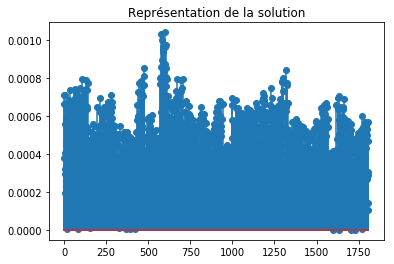

In [97]:
plt.stem(c_star)
titre = 'Représentation de la solution'
plt.title(titre)

KeyboardInterrupt: 

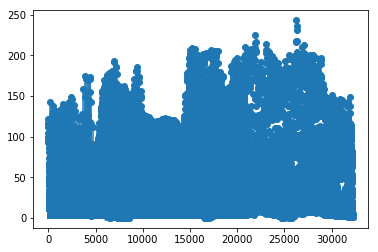

In [238]:
plt.stem(y)
titre = 'Représentation du signal'
plt.title(titre)

KeyboardInterrupt: 

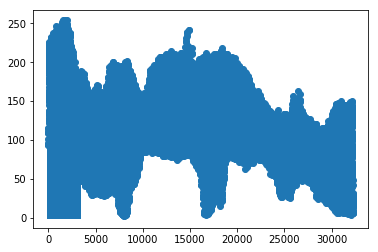

In [137]:
plt.stem(e_star)
titre = 'Représentation des erreurs'
plt.title(titre)

In [ ]:
y_rebuilt=A.dot(c)+e_star
plt.stem(y_rebuilt)
titre = 'Représentation de la reconstruction'
plt.title(titre)

In [100]:
#http://paperity.org/p/73780933/a-fast-and-accurate-algorithm-for-1-minimization-problems-in-compressive-sampling
#another way to solve the problem

#init
v=np.zeros(m)
u=np.zeros(N)
eps=1

normA=np.linalg.norm(A)
alpha=0.0025
beta=0.999*alpha/(normA**2)
bona=beta/alpha

AtA=A.T.dot(A)
Id=np.eye(shape(AtA))

KeyboardInterrupt: 

In [ ]:
#take time...
AtA=At.dot(A)

In [ ]:
for k in range(max_iter):
    #step 1
    u=shrink((Id-bona*AtA).dot(u)-bona*A.T.dot(v-w))
    #step 2
    p=A.dot(u)+v-y
    if norm2(p)<eps:
        w=A.do(u)+v
    else:
        w=y+eps*p/norm2(p)
    #step 3
    v=A.dot(u)+v-w

In [61]:
#http://paperity.org/p/73780933/a-fast-and-accurate-algorithm-for-1-minimization-problems-in-compressive-sampling
#another way to solve the problem

#init
u=np.zeros(N)
v1=np.zeros(m)
v0=v1-(A.dot(u))
eps=0.1

normA=np.linalg.norm(A)
#alpha=0.0025
alpha=(m/N)*20*(normA**2)/np.linalg.norm(At.dot(y),np.inf)
beta=0.999*alpha/(normA**2)
bona=beta/alpha

T=6
tau=4
l=20

max_iter=400

In [45]:
shrink(u-bona*At.dot(2*v1-v0),1/alpha)
u-bona*At.dot(2*v1-v0)
shrink(u-bona*At.dot(2*v1-v0),1/alpha)

array([0., 0., 0., ..., 0., 0., 0.])

In [62]:
#a variant
for k in range(max_iter):
    #step 1
    u=shrink(u-bona*At.dot(2*v1-v0),1/alpha)
    #step 2
    p=A.dot(u)+v1-y
    v0=v1
    if norm2(p)<eps:
        v1=0
    else:
        v1=(1-eps/norm2(p))*p
    #step 3
    if k%l==0 and T<20:
        alpha=tau*alpha
        beta=tau*beta
        bona=beta/alpha
        T+=1
    print(u)

[0. 0. 0. ... 0. 0. 0.]
[2.22053665e-04 4.02049877e-04 5.06840644e-05 ... 1.55079516e-04
 3.16323649e-05 3.30770594e-04]
[1.69619113e-04 6.14797740e-04 3.99241821e-06 ... 5.27119262e-05
 1.68423999e-05 4.80472247e-04]
[ 2.02755523e-05  7.54582130e-04 -5.44680869e-05 ... -1.38723928e-04
 -1.43332333e-06  5.52126289e-04]
[-1.09178031e-04  8.89662509e-04 -6.71083736e-05 ... -3.07746553e-04
  4.50870524e-06  6.06107608e-04]
[-1.99873912e-04  1.01266294e-03 -1.91604131e-05 ... -4.31976172e-04
  4.12479869e-05  6.35716758e-04]
[-2.71504191e-04  1.09337405e-03  8.20895152e-05 ... -5.26503915e-04
  1.03672638e-04  6.14030805e-04]
[-0.00033933  0.00111658  0.00022523 ... -0.00060491  0.00018392
  0.00052747]
[-0.00040601  0.0010876   0.0003979  ... -0.00067152  0.00027362
  0.0003807 ]
[-0.000469    0.00102303  0.00058603 ... -0.00072751  0.00036346
  0.00018846]
[-5.26755430e-04  9.42006322e-04  7.73488627e-04 ... -7.75712389e-04
  4.43159760e-04 -3.18614522e-05]
[-0.00057983  0.00086193  0.00

[-0.0050282   0.01049004  0.00518499 ... -0.00211537  0.00390754
 -0.0127071 ]
[-0.005176    0.01055994  0.00514125 ... -0.00199851  0.00366708
 -0.01270362]
[-0.00532381  0.01062721  0.0050863  ... -0.00187585  0.00341198
 -0.012697  ]
[-0.00547168  0.01069216  0.00502167 ... -0.0017481   0.00314427
 -0.0126868 ]
[-0.00561975  0.01075512  0.00494898 ... -0.00161605  0.00286607
 -0.01267261]
[-0.00576815  0.01081642  0.00486999 ... -0.00148049  0.00257961
 -0.01265401]
[-0.00591704  0.0108764   0.00478645 ... -0.00134226  0.00228717
 -0.01263056]
[-0.00606662  0.01093536  0.00470016 ... -0.00120217  0.00199101
 -0.01260188]
[-0.00621705  0.0109936   0.00461288 ... -0.00106102  0.00169337
 -0.01256761]
[-0.00636852  0.0110514   0.00452629 ... -0.00091957  0.00139642
 -0.01252741]
[-0.00652119  0.01110899  0.00444201 ... -0.00077855  0.00110222
 -0.01248104]
[-0.00667523  0.01116658  0.0043615  ... -0.00063859  0.00081269
 -0.01242826]
[-0.00683075  0.01122433  0.00428608 ... -0.00050028

[-0.01793091  0.00623966  0.00594661 ...  0.00196669 -0.0058506
 -0.01109504]
[-0.01803063  0.00607126  0.00588612 ...  0.00187825 -0.00590806
 -0.01121265]
[-0.01813027  0.00590172  0.00582381 ...  0.00178711 -0.00596131
 -0.01133026]
[-0.01822971  0.00573095  0.00575952 ...  0.00169339 -0.00601041
 -0.01144792]
[-0.01832884  0.00555887  0.00569312 ...  0.00159721 -0.00605542
 -0.01156568]
[-0.01842755  0.00538541  0.00562454 ...  0.00149867 -0.00609638
 -0.01168358]
[-0.01852576  0.00521047  0.00555375 ...  0.00139789 -0.00613331
 -0.01180169]
[-0.01862341  0.00503398  0.00548076 ...  0.00129495 -0.00616618
 -0.01192005]
[-0.01872044  0.00485587  0.00540567 ...  0.00118994 -0.00619493
 -0.01203871]
[-0.01881682  0.00467606  0.00532859 ...  0.00108291 -0.00621947
 -0.01215769]
[-0.01891254  0.0044945   0.00524972 ...  0.00097393 -0.00623967
 -0.01227702]
[-0.01900758  0.00431112  0.00516931 ...  0.00086303 -0.00625537
 -0.01239673]
[-0.01910197  0.00412587  0.00508765 ...  0.00075023 

[-0.0227741  -0.01659106  0.00429784 ... -0.0076803   0.00119102
 -0.01270961]
[-0.02274877 -0.0168389   0.00429544 ... -0.00772409  0.001174
 -0.01256716]
[-0.02272053 -0.01708705  0.00429372 ... -0.00776887  0.00115652
 -0.01242503]
[-0.02268927 -0.01733542  0.00429283 ... -0.00781462  0.00113889
 -0.01228331]
[-0.0226549  -0.01758392  0.00429291 ... -0.00786136  0.00112143
 -0.0121421 ]
[-0.02261731 -0.01783244  0.00429408 ... -0.00790905  0.00110442
 -0.01200146]
[-0.02257637 -0.01808086  0.00429647 ... -0.00795769  0.00108816
 -0.01186148]
[-0.02253199 -0.01832907  0.00430015 ... -0.00800721  0.00107291
 -0.0117222 ]
[-0.02248403 -0.01857695  0.00430521 ... -0.0080576   0.00105895
 -0.01158368]
[-0.02243238 -0.01882436  0.00431171 ... -0.00810878  0.00104652
 -0.01144595]
[-0.02237692 -0.01907117  0.0043197  ... -0.00816071  0.00103585
 -0.01130905]
[-0.02231752 -0.01931725  0.00432922 ... -0.00821332  0.00102718
 -0.01117299]
[-0.02225408 -0.01956245  0.00434029 ... -0.00826654  

Text(0.5,1,'Représentation de la solution')

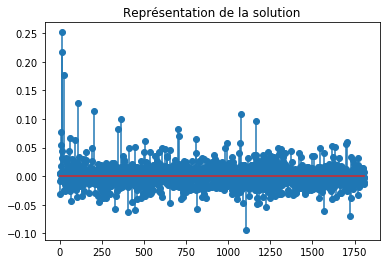

In [63]:
plt.stem(u)
titre = 'Représentation de la solution'
plt.title(titre)